# Multi-nomial Naive Bayes Classifier

## Steps for classification using Naive Bayes for sentiment analysis:

1. `Clean text data` - different options depending on how you structure your model. I remove punctuation and stopwords, convert to lowercase, and transform each review into a bag of words

2. `Calculate prior probabilities` - calculate the percent of all reviews that are in each class (pos or neg)

3. `Calculate maximum likelihood probability` - for each word in a review, calculate its frequency in each class bag of words. Apply laplace smoothing here as well to avoid possible 0 probabilities and use logs to speed up calculation time

4. `Argmax` - after getting the maximum likelihood estimate for each class, take the argmax of the results to get which class each test review belongs to (0 = negative, 1 = positive)

In [2]:
from collections import defaultdict, Counter
from math import log, exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from text_preprocessor import process_df,tokenizer

cleaned_df = process_df("ice_cream_reviews.csv", to_drop=["author", "date", "helpful_yes", "helpful_no"])

# 3732 for training (80%), 1600 (20%) for testing, 
X_train = cleaned_df[1600:]
print(len(X_train))

X_test = cleaned_df[:1600]
print(len(X_test))


3732
1600


In [3]:
class NaiveBayesClassifier:
    """
    My take on a Multinomial Naive Bayes Classifier in Python
    ...
    
    Attributes:
    ----------
    
        train_data (pd.DataFrame): training data
        test_data  (pd.DataFrame): testing data
        pos/neg_entries (pd.Series): entries from training data split into pos and neg classes
        pos/neg_vocab (list): lists of all words appearing in each class
        pos/neg_BoW (dict) : frequency dict of each word per class
    
    Methods:
    --------

        _BoW(doc): 
            helper method for converting pos and neg vocabs into bags of words
        
        _Pprob(c):
            helper method for calculating the prior probability for pos and neg classes
            
        _MLprob(sentence):
            helper method for calculating the maximum likelihood estimates
            
        get_scores(extra):
            calculates accuracy, precision, recall, f1-score
            
        classification_report(extra=False):
            prints a classification report containing results from get_scores
            
        predict(sentence):
            uses _MLprob to calculate maximum likelihood estimate for an input sentence
            
        plot_most_common_counts(option, n):
            plots n most common words depending on given class option
    """
    
    def __init__(self, train_data, test_data):
        
        self.train = train_data
        self.test = test_data
       
        # separate positive and negative reviews
        self.pos_entries = self.train.loc[self.train["sentiment"]==1]
        self.neg_entries = self.train.loc[self.train["sentiment"]==0]
    
        # all words from each class (need to be lists since I turn them into bag of words)
        self.pos_vocab = [word for review in self.pos_entries["review"] for word in review.split()]
        self.neg_vocab = [word for review in self.neg_entries["review"] for word in review.split()]
       
        self.pos_BoW = self._BoW(self.pos_vocab)
        self.neg_BoW = self._BoW(self.neg_vocab)
    
    def _BoW(self, doc):
        """
        Turns a sentence into a bag of words 
        
        Args:
            doc (str): sentence to be turned into a bag of words
        Returns
            A dictionary containing unique word wounts
        
        """
        d = defaultdict(lambda:0)
        for word in doc:
            d[word]+=1  
        return dict(d)

    def _Pprob(self, c):
        """
        Calculates the prior probability of class c
        Formula: # of c class entries / # of all documents
        
        Args:
            c (str): class to be calculated
        Returns:
            Prior probability of a class (log)
        """
        return log(len(c) / (len(self.train)))
    
    # maxiumum likelihood probability
    def _MLprob(self, sentence):
        """
        calculates the maximum likelihood estimate given all classes
        
        Args:
            sentence (str): string to undergo calculation
        Returns:
            Returns the index of the highest probability score  
        """
        
        sentence = tokenizer(sentence)
        scores = [] 
        
        # positive and negative log prior probability
        pos_prob = self._Pprob(self.pos_entries)
        neg_prob = self._Pprob(self.neg_entries)
        
        # calculates the likelihood probability of each word given the class prior probability
        for word in sentence: 
                try:
                    w = self.neg_BoW[word] + 1 # laplace smoothing (+1)
                    V = (len(self.neg_BoW)+ len(self.train))
                    neg_prob += log(w / V)
                except:
                    pass     
        scores.append(exp(neg_prob)) 
        
        for word in sentence: 
                try:
                    w = self.pos_BoW[word]+ 1
                    V = (len(self.pos_BoW)+ len(self.train))
                    pos_prob += log(w / V)
                except:
                    pass 
        scores.append(exp(pos_prob))
        
        # index 0 == negative, index 1 == positive
        return np.argmax(np.array(scores))
      
    def get_scores(self, extra):
        """
        Uses _MLprob and test data to calculate accuracy, precision, recall, f1-score
        
        Args:
            extra (bool): option to print the true/false pos/neg scores
        Returns:
            accuracy: out of all predictions, how many were correct
            precision: out of all positive predictions, how many are actually positive
            recall: out of all actual positives, how many positive predictions are correct
            f1score: harmonic mean of precision and recall
        """
         
        true_pos = 0
        false_pos = 0
        true_neg = 0
        false_neg = 0
        
        test_reviews = self.test["review"]
        test_labels = self.test["sentiment"]
        
        for label, review in zip(test_labels, test_reviews):
            
            MLprob = self._MLprob(review)
            
            if MLprob == 0 and label == 0:   # predicted neg, label neg 
                true_neg += 1
                
            elif MLprob == 1 and label == 1: # predicted pos, label pos
                true_pos += 1  
                
            elif MLprob == 0 and label == 1: # predicted neg, label pos
                false_neg += 1
                
            elif MLprob == 1 and label == 0: # predicted pos, label neg
                false_pos += 1 
                
        # option to print out more details about the results if desired
        if extra:
            print("TN:",true_neg)
            print("TP:",true_pos)
            print("FN:",false_neg)
            print("FP:",false_pos)
              
        accuracy = (true_neg + true_pos) / (true_pos + true_neg + false_neg + false_pos)
        precision = (true_pos) / (true_pos + false_pos)
        recall = (true_pos) / (true_pos + false_neg)
        f1score = (2* (precision*recall)) / (precision + recall)
        
        return round(accuracy,3), round(precision,3), round(recall,3), round(f1score, 3)
        
    def classification_report(self, extra=False):
        """
        Prints a report showing accuracy, precision, recall, f1-score
        
        Args:
            extra (bool): option to print the true/false pos/neg scores
        Returns:
            None
        """
        
        accuracy, precision, recall, f1score = self.get_scores(extra)
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1score}")
        
    def predict(self, review):
        """
        Callable method to calculate the maxiumum likelihood estimate of an input review
        
        Args:
            review (str): review to be calculated
        Returns:
            prediction value (0 or 1) 
        """
        return self._MLprob(review)
    
    def plot_most_common_counts(self,option, n):
        """
        Displays a plot of n word counts for specified class (long tail distribution)
        
        Args:
            option (str): class to be displayed ("pos" or "neg")
            n (int): # of words to display
        Returns:
            None
        """
        
        # gets unreadable after 150
        
        if option == "pos":
            
            C = Counter(self.pos_BoW).most_common(n)
            X,y = [word[0] for word in C], [word[1] for word in C]
            f = plt.figure()
            f.set_figwidth(20)
            plt.title("Positive Sentiment Word Frequencies")
           
        elif option == "neg":
            C = Counter(self.neg_BoW).most_common(n)
            X,y = [word[0] for word in C], [word[1] for word in C]
            f = plt.figure()
            f.set_figwidth(20)
            plt.title("Negative Sentiment Word Frequencies")
            
        plt.xticks(rotation=90)
        plt.xlabel("Words")
        plt.ylabel("Frequencies")
        plt.plot(X,y)
        plt.show
            
        
        

# instantiate and fit the model to data
model = NaiveBayesClassifier(X_train, X_test)


In [3]:
model.classification_report(extra=True)

TN: 103
TP: 1009
FN: 257
FP: 231
Accuracy: 0.695
Precision: 0.814
Recall: 0.797
F1-score: 0.805


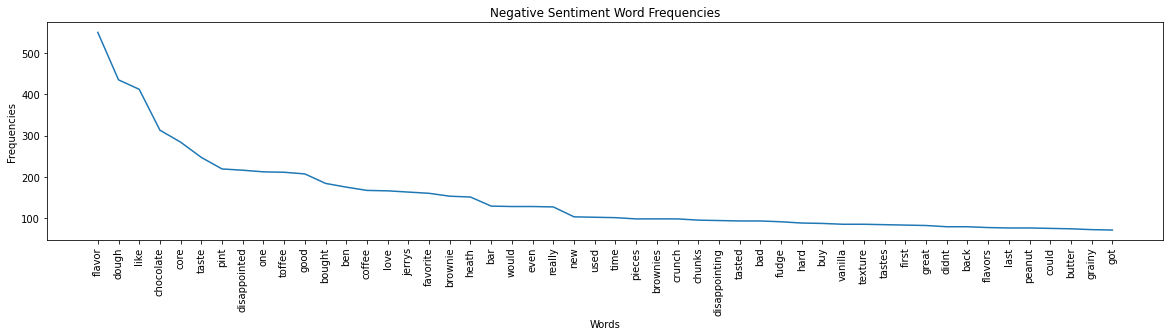

In [5]:
model.plot_most_common_counts("neg", 50)

In [17]:

print("Correct classifications")
print(f"""LABEL: 0 PREDICTION: {model.predict("This ice cream tastes awful! Most disgusting thing I've ever had")}""") 
print(f"""LABEL: 1 PREDICTION: {model.predict("I LOVE this flavor. I wish it was a little mintier, but whatever. Very good!")}""")
print(f"""LABEL: 0 PREDICTION: {model.predict("Tastes terrible. I swear it used to be good. What happened???")}""") 

print("Incorrect classifications")
print(f"""LABEL: 1 PREDICTION: {model.predict("I LOVE this ice cream, but the chunks are so gross and awful")}""") 
print(f"""LABEL: 0 PREDICTION: {model.predict("This ice cream sucks")}""") 
print(f"""LABEL: 1 PREDICTION: {model.predict("Only one critique: its too salty!! The saltiness is super disgusting. Otherwise, its okay")}""") 



Correct classifications
LABEL: 0 PREDICTION: 0
LABEL: 1 PREDICTION: 1
LABEL: 0 PREDICTION: 0
Incorrect classifications
LABEL: 1 PREDICTION: 0
LABEL: 0 PREDICTION: 1
LABEL: 1 PREDICTION: 0


1